In [1]:
import qiskit
print(qiskit.version.get_version_info())

1.1.1


In [2]:
# Step 1 -- Distributable Quantum Circuit
# Input: N/D.
# Output: `circuit`.

from qiskit import QuantumCircuit

circuit = QuantumCircuit(10)
circuit.cx(0, 1)
circuit.cx(2, 3)
circuit.cx(4, 5)
circuit.cx(4, 5)
circuit.cx(4, 5)
circuit.cx(4, 5)
circuit.cx(6, 7)
circuit.cx(8, 9)
circuit.cx(1, 2)
circuit.cx(3, 4)
circuit.cx(3, 4)
circuit.cx(5, 6)
circuit.cx(7, 8)
#circuit.cx(9, 0)
#circuit.cx(9, 0)
#circuit.cx(9, 0)

print(circuit)

                                   
q_0: ──■───────────────────────────
     ┌─┴─┐                         
q_1: ┤ X ├──■──────────────────────
     └───┘┌─┴─┐                    
q_2: ──■──┤ X ├────────────────────
     ┌─┴─┐└───┘                    
q_3: ┤ X ├─────────────────■────■──
     └───┘               ┌─┴─┐┌─┴─┐
q_4: ──■────■────■────■──┤ X ├┤ X ├
     ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐└───┘└───┘
q_5: ┤ X ├┤ X ├┤ X ├┤ X ├──■───────
     └───┘└───┘└───┘└───┘┌─┴─┐     
q_6: ──■─────────────────┤ X ├─────
     ┌─┴─┐               └───┘     
q_7: ┤ X ├──■──────────────────────
     └───┘┌─┴─┐                    
q_8: ──■──┤ X ├────────────────────
     ┌─┴─┐└───┘                    
q_9: ┤ X ├─────────────────────────
     └───┘                         


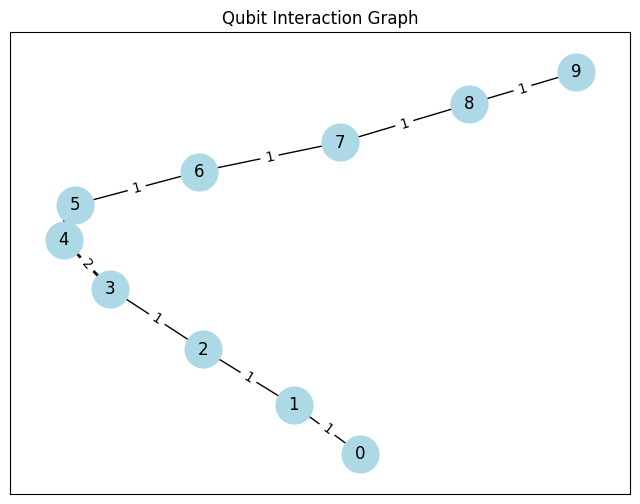

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

def create_qubit_interaction_graph(circuit):
    """Creates a graph based on the quantum circuit where nodes are qubits and edges
    are weighted by the number of 2-qubit gates between them."""
    
    # Initialize a graph
    G = nx.Graph()
    
    # Add nodes for each qubit
    for qubit in range(circuit.num_qubits):
        G.add_node(qubit)
    
    # Iterate through the circuit to find 2-qubit gates and update edge weights
    for gate in circuit.data:
        if len(gate[1]) == 2:  # If the gate acts on two qubits
            qubit1 = circuit.find_bit(gate[1][0])[0]
            qubit2 = circuit.find_bit(gate[1][1])[0]            
            if G.has_edge(qubit1, qubit2):
                G[qubit1][qubit2]['weight'] += 1
            else:
                G.add_edge(qubit1, qubit2, weight=1)

    return G

def get_color(index):
    if index == 0:
        return 'lightblue'
    elif index == 1:
        return 'lightpink'
    elif index == 2:
        return 'lightgreen'
    else:
        return 'lightgray'

def plot_qubit_interaction_graph(G, title, clusters = None):
    """Plots the qubit interaction graph."""
    pos = nx.spring_layout(G)  # Layout for a visually appealing graph
    plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
    
    # Draw nodes
    if clusters is None:
        nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700)
    else:
        color = 0
        for cluster in clusters:
            nx.draw_networkx_nodes(G, pos, nodelist=cluster, node_color=get_color(color), node_size=700)
            color = color + 1
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')
    
    # Draw edges with weights
    edges = G.edges(data=True)
    weights = [d['weight'] for (u, v, d) in edges]
    
    if edges:  # Ensure there are edges to draw
        nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights)
        edge_labels = {(u, v): d['weight'] for u, v, d in edges}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    plt.title(title)
    plt.show()

# Create the qubit interaction graph
G = create_qubit_interaction_graph(circuit)

# Plot the graph
plot_qubit_interaction_graph(G, "Qubit Interaction Graph")

[frozenset({8, 9, 6, 7}), frozenset({0, 1}), frozenset({2, 3}), frozenset({4, 5})]


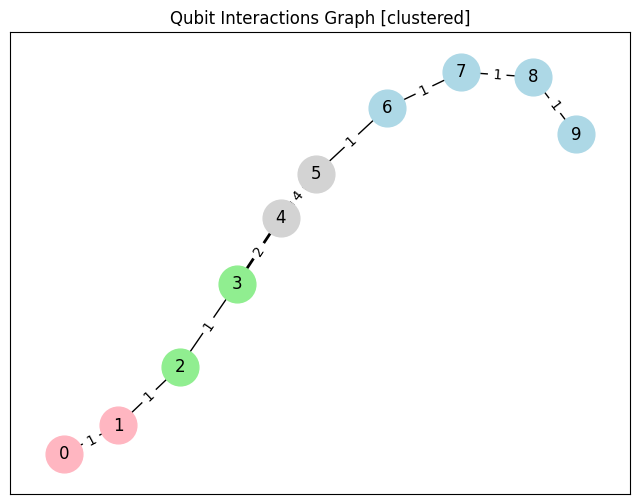

In [4]:
# Step 2 -- Break down algorithm
# Input: `circuit`.
# Output: `distribution_map`.

import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity
from itertools import combinations
import random

def calculate_edge_cut(G, nodes1, nodes2):
    cut_value = 0
    for u in nodes1:
        for v in nodes2:
            if G.has_edge(u, v):
                cut_value += G[u][v].get('weight')
    return cut_value

def divide_graph(G, n):
    return list(greedy_modularity_communities(G, weight='weight', cutoff=n, best_n=n))

clusters = divide_graph(G, 4)
print(clusters)

plot_qubit_interaction_graph(G, "Qubit Interactions Graph [clustered]", clusters)